In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

In [2]:
credit = pd.read_csv('../Credit.csv')

In [3]:
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,2,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,3,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [4]:
credit.shape

(1000, 21)

In [5]:
credit.dtypes

checking_status           object
duration                   int64
credit_history            object
purpose                   object
credit_amount              int64
savings_status            object
employment                object
installment_commitment     int64
personal_status           object
other_parties             object
residence_since            int64
property_magnitude        object
age                        int64
other_payment_plans       object
housing                   object
existing_credits           int64
job                       object
num_dependents             int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

Transformação básica de categórica pra numérica com o próprio pandas

In [6]:
for col in credit.columns:
    if credit[col].dtype == 'object':
        credit[col] = credit[col].astype('category').cat.codes

In [7]:
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,4,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,2,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,3,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,4,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,4,1,53,1,0,2,3,2,0,1,0


In [8]:
X = credit.iloc[:, 0:20].values #vai de 0 a 19
y = credit.iloc[:, 20].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criação do modelo e do experimento

2025/02/05 11:12:38 INFO mlflow.tracking.fluent: Experiment with name 'nbexperiment' does not exist. Creating a new experiment.


Model:  c70a5153c3d14498a770f38e2fddabd3


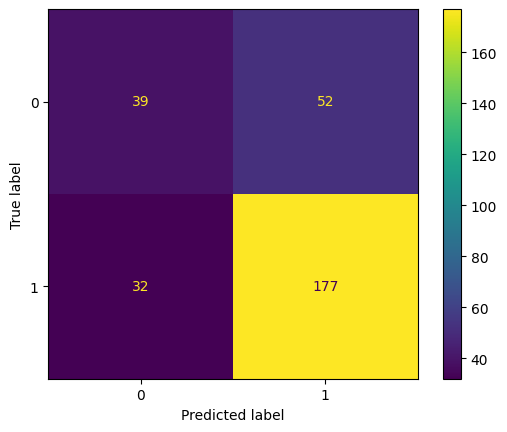

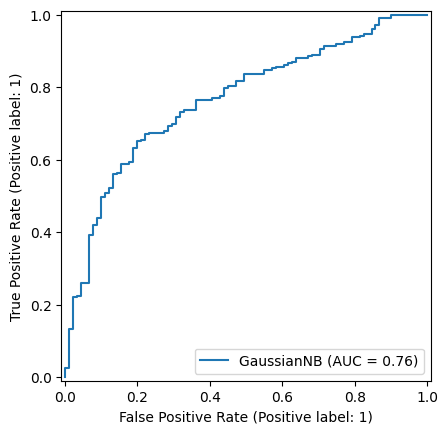

In [12]:
mlflow. set_experiment("nbexperiment")

with mlflow.start_run():
    naive_bayes = GaussianNB()
    naive_bayes.fit(X_train, y_train)
    prevs = naive_bayes.predict(X_test)
    
    #metrics
    acc = accuracy_score(y_test, prevs)
    recall = recall_score(y_test, prevs)
    precision = precision_score(y_test, prevs)
    auc = roc_auc_score(y_test, prevs)
    log = log_loss(y_test, prevs)

    #register metrics
    mlflow.log_metric("Accuracy: ", acc)
    mlflow.log_metric("Recall: ", recall)
    mlflow.log_metric("Precision: ", precision)
    mlflow.log_metric("Auc: ", auc)
    mlflow.log_metric("Log: ", log)

    #plots
    confusion = ConfusionMatrixDisplay.from_estimator(naive_bayes, X_test, y_test)
    plt.savefig("confusionnb.png")
    roc = RocCurveDisplay.from_estimator(naive_bayes, X_test, y_test)
    plt.savefig("rocnb.png")

    #register plots
    mlflow.log_artifact("confusionnb.png")
    mlflow.log_artifact("rocnb.png")   

    #register model
    signature = infer_signature(X_train, naive_bayes.predict(X_train))
    mlflow.sklearn.log_model(naive_bayes,
                             "NBmodel",
                             signature=signature)
    
    #execution infos
    print("Model: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()